In [1]:
from PIL import Image
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import os
import torch
import torch.utils.data

In [2]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

In [3]:
from torch.utils.tensorboard import SummaryWriter

In [4]:
import sys
sys.path.insert(0,'C:/git/vision/references/detection/')

from engine import train_one_epoch, evaluate
import utils
import transforms as T

In [5]:
## used for image augmentation 
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

In [6]:
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

In [7]:
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler
import xml.etree.ElementTree as ET

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [9]:
from tqdm.notebook import tqdm

In [10]:
def parse_xml(file_xml, file_path='C:/Users/yanzliu/Desktop/bad_result'):
    annotation_path = os.path.join(file_path, file_xml)
    tree = ET.parse(annotation_path)
    root = tree.getroot()
    objects = root.findall('object')
    bbox = list()
    ant = list()
    for obj in objects:                           
        bndbox = obj.find('bndbox')
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)
        bbox.append((xmin, ymin, xmax, ymax))
        antion = obj.find('name').text
        ant.append(antion)
    return bbox, ant

### 检测一下图片的标注是否全都准确

In [50]:
xml_path = """C:/Users/yanzliu/Desktop/bad_result"""
image_path = r"""C:\Users\yanzliu\Desktop\img_bad"""

In [52]:
xml_path2 = r"""C:\Users\yanzliu\Desktop\b2"""
image_path2 = r"""C:\Users\yanzliu\Desktop\img2"""

In [12]:
old_path = r"""C:\Users\yanzliu\Downloads\pic-similarity\img_for_yishi"""

In [13]:
old_list = [i[:-3] for i in os.listdir(old_path)]

In [116]:
xml_list = os.listdir(xml_path2)

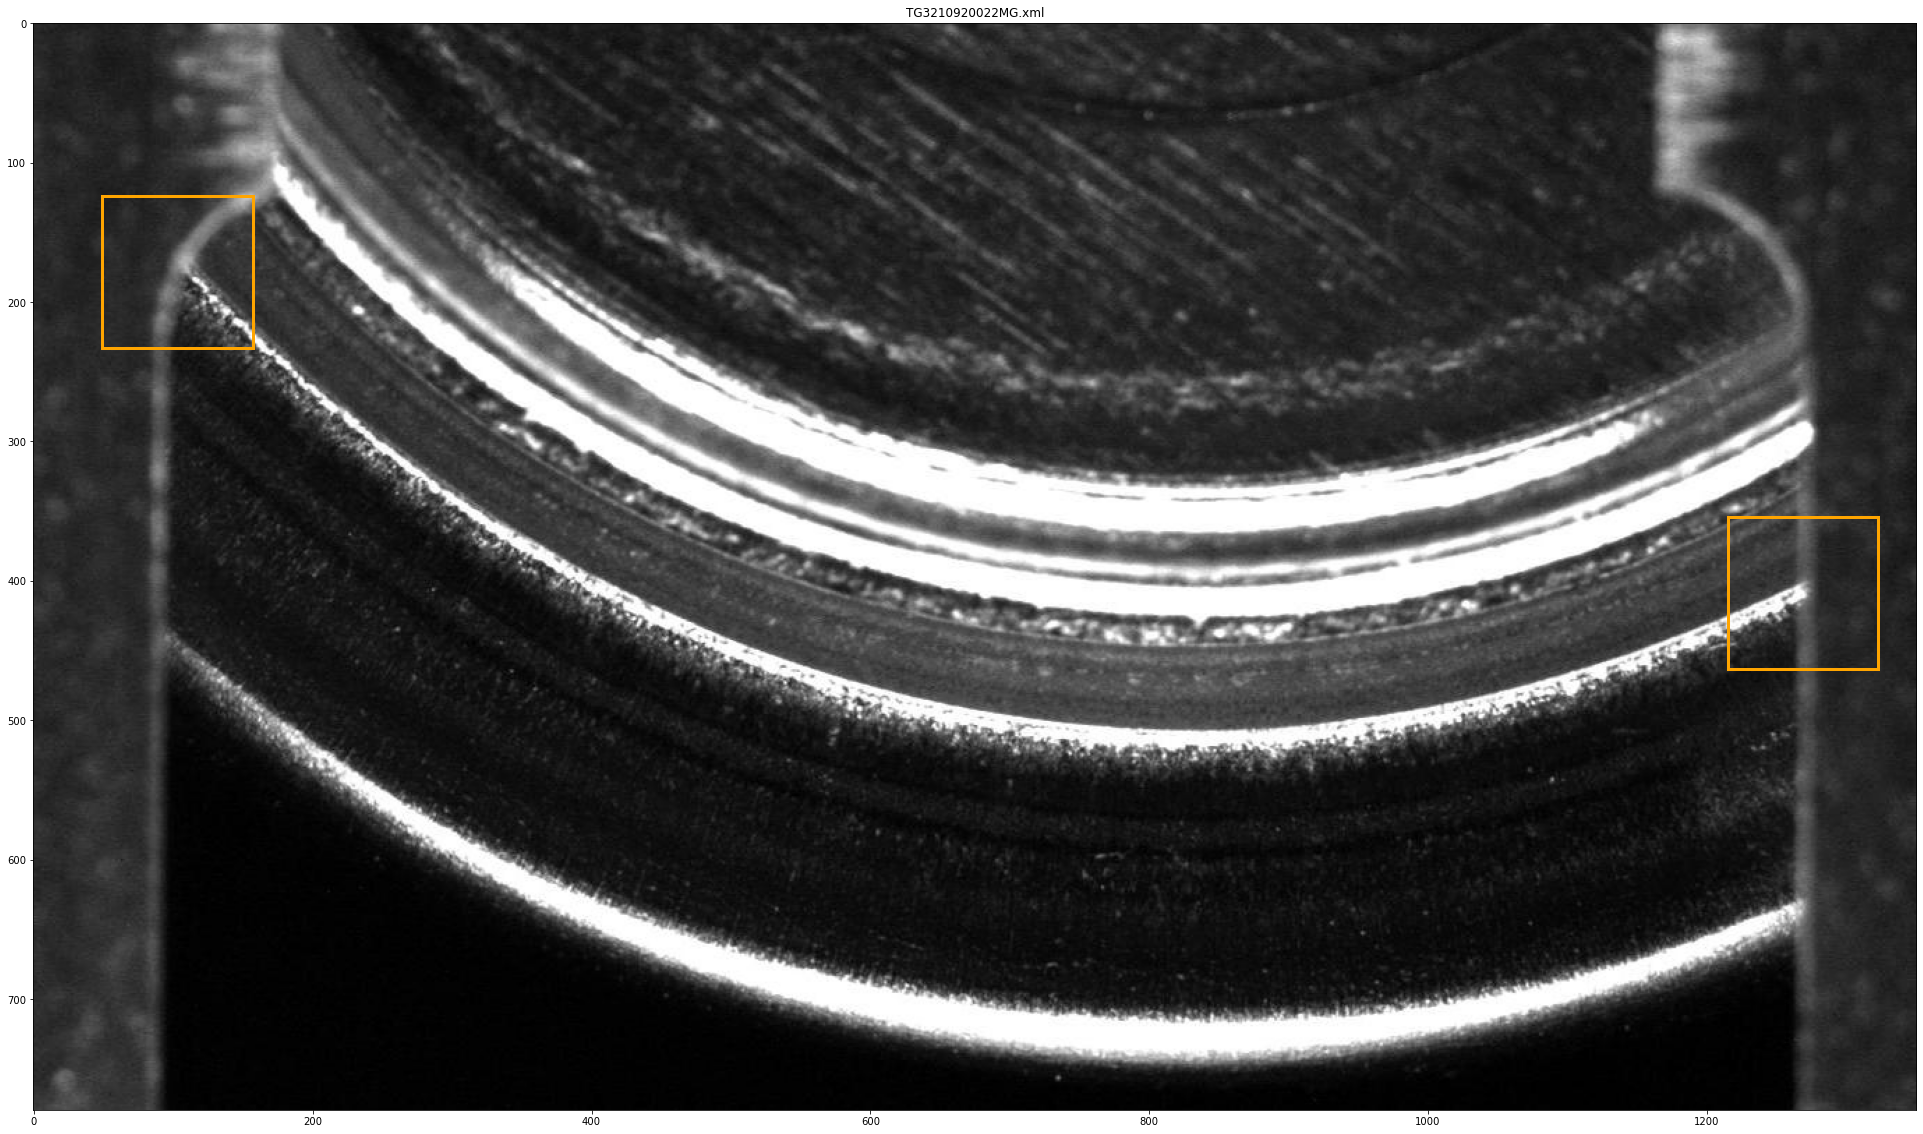

In [117]:
for xml in tqdm(xml_list):
    full_path = os.path.join(image_path, xml[:-3]+'jpg')
    plt.figure(figsize=(40,20))
    plt.imshow(Image.open(full_path).convert("RGB"))
    box_, annotation = parse_xml(file_xml=xml)
    if len(box_) == 2:
        plt.gca().add_patch(plt.Rectangle(xy=(box_[0][0], box_[0][1]), width=box_[0][2]-box_[0][0], height=box_[0][3]-box_[0][1], fill=False, linewidth=3, edgecolor='orange'))
        plt.gca().add_patch(plt.Rectangle(xy=(box_[1][0], box_[1][1]), width=box_[1][2]-box_[1][0], height=box_[1][3]-box_[1][1], fill=False, linewidth=3, edgecolor='orange'))
    else:
        plt.gca().add_patch(plt.Rectangle(xy=(box_[0][0], box_[0][1]), width=box_[0][2]-box_[0][0], height=box_[0][3]-box_[0][1], fill=False, linewidth=3, edgecolor='orange'))
    plt.title(xml)
    #plt.savefig('C:/Users/yanzliu/Desktop/test_img/' + xml[:-3] + 'png')
    #plt.close()

In [94]:
### 标注全部正确

### re-training

In [161]:
model = torch.load('C:/Users/yanzliu/Desktop/pytorch_model/f_rcnn_v3.pkl')

In [131]:
##制作数据集

class BatteryDataset(torch.utils.data.Dataset):
    def __init__(self, transforms=None):
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.annotations = [i for i in xml_list]
        self.imgs = [i[:-3] + 'jpg' for i in self.annotations]

    def __getitem__(self, idx):
        # load images ad annotations
        img_path = os.path.join(image_path, self.imgs[idx])
        label_path = os.path.join(xml_path, self.annotations[idx])
        img = Image.open(img_path).convert("RGB")

        # get bounding box coordinates
        boxes, annotation = parse_xml(file_xml=self.annotations[idx])
        num_objs = len(boxes)
        
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [132]:
dataset = BatteryDataset()

In [133]:
len(dataset)

1

### helper function for data argumentation

In [134]:
##加一个50%概率的水平翻转

def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

### putting everything together

In [135]:
# use our dataset and defined transformations
dataset = BatteryDataset(get_transform(train=True))

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=1, shuffle=True, num_workers=0,
    collate_fn=utils.collate_fn)

In [154]:
optimizer = torch.optim.SGD(params, lr=0.01,
                            momentum=0.9, weight_decay=0.0005)

lr_scheduler_normal = torch.optim.lr_scheduler.StepLR(optimizer,
                                                      step_size=50,
                                                      gamma=0.1)

In [155]:
num_epochs = 5

# move model to the right device
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256)
          (relu): ReLU(inplace=True)
          (downsample)

In [101]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.03,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler_normal = torch.optim.lr_scheduler.StepLR(optimizer,
                                                      step_size=10,
                                                      gamma=0.1)

lr_scheduler_warmup = utils.warmup_lr_scheduler(optimizer,
                                                warmup_iters=100,
                                                warmup_factor=1./100)

num_epochs = 50

In [156]:
writer = SummaryWriter()

In [157]:
## 先做warmup
## 加一个early_stopping
iters = 0
best_test_loss = 100

for epoch in range(num_epochs):
    model.train()
    losses_train = 0
    for images, targets in data_loader:
        
        iters += 1
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k,v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        ##输出损失函数
        writer.add_scalar("Loss/train", losses, iters)
        loss_value = losses.item()
        print(f"Iteration #{iters} loss: {loss_value}")
        losses_train += loss_value

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        lr_scheduler_normal.step()
    print('------------------------------------------------------------------')
    print(f"-----------Epoch #{epoch} train loss: {losses_train/ len(data_loader)}")
#    with torch.no_grad():
#        losses_test = 0
#        for images_, targets_ in data_loader_test:
#            images_ = list(image.to(device) for image in images_)
#            targets_ = [{k: v.to(device) for k,v in t.items()} for t in targets_]
#            
#            loss_dict_test = model(images, targets)
#            losses_test += sum(loss for loss in loss_dict_test.values())
#        losses_test = losses_test / len(data_loader_test)
#        writer.add_scalar("Loss/test", losses_test, epoch)
#        loss_value_test = losses_test.item()
#        print(f"-----------Epoch #{epoch} test loss: {loss_value_test}")
#        ## early stopping
#        ##if loss_value_test <= best_test_loss:
#        ##    best_test_loss = loss_value_test
#        ##    es=0
#        ##else:
#        ##    es+=1
#        ##if es > 8:
#        ##    break
#        ##
writer.close()

Iteration #1 loss: 0.2761533558368683
------------------------------------------------------------------
-----------Epoch #0 train loss: 0.2761533558368683
Iteration #2 loss: 0.34121593832969666
------------------------------------------------------------------
-----------Epoch #1 train loss: 0.34121593832969666
Iteration #3 loss: 0.24582473933696747
------------------------------------------------------------------
-----------Epoch #2 train loss: 0.24582473933696747
Iteration #4 loss: 0.2909166216850281
------------------------------------------------------------------
-----------Epoch #3 train loss: 0.2909166216850281
Iteration #5 loss: 0.3565603792667389
------------------------------------------------------------------
-----------Epoch #4 train loss: 0.3565603792667389


### test with 50 new images

In [149]:
test_path = r'C:\Users\yanzliu\Downloads\pic-similarity\img_pil_cut'

In [150]:
file_test = os.listdir(image_path)#[-150:-100]

In [158]:
## image转tensor
file_array = np.array((Image.open(os.path.join(image_path, 'TG3210920022MG.jpg'))), dtype=np.float32)
file_array /= 255.0
file_torch = torch.from_numpy(np.transpose(file_array, (2,0,1)))

In [159]:
model.eval()
with torch.no_grad():
    prediction = model([file_torch.to(device)])

In [160]:
prediction

[{'boxes': tensor([[1220.0050,  356.7472, 1318.8473,  456.5635],
          [1216.1083,  585.6499, 1315.5642,  684.7433],
          [  39.8072,  394.1041,  142.2643,  492.1525],
          [  62.0150,  136.2120,  161.7152,  228.8044],
          [ 125.1448,   54.6733,  220.1730,  152.7728],
          [1226.7333,  238.2490, 1322.9731,  344.2712],
          [1218.5881,  280.3253, 1317.7811,  431.8690]], device='cuda:0'),
  'labels': tensor([1, 1, 1, 1, 1, 1, 1], device='cuda:0'),
  'scores': tensor([0.9980, 0.9940, 0.9939, 0.9829, 0.9472, 0.8747, 0.3203],
         device='cuda:0')}]

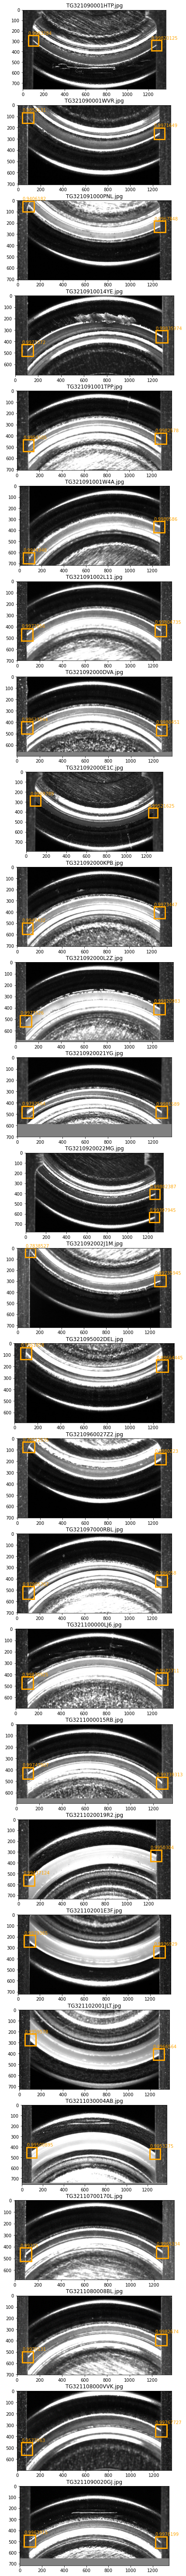

In [162]:
plt.figure(figsize=(20, 200))

for idx, file in enumerate(file_test):
    ## image转tensor
    file_array = np.array((Image.open(os.path.join(image_path, file))), dtype=np.float32)
    file_array /= 255.0
    file_torch = torch.from_numpy(np.transpose(file_array, (2,0,1)))
    
    ## prediction & plot
    model.eval()
    with torch.no_grad():
        prediction = model([file_torch.to(device)])
    
    plt.subplot(50, 1, idx+1)
    plt.imshow(file_array)
    bx = prediction[0]['boxes'].cpu().numpy().shape[0]
    n = 1 if bx == 1 else 2
    for j in range(n):
        rect_co = prediction[0]['boxes'].cpu().numpy()[j]
        x = rect_co[1]
        y = rect_co[0]
        width = rect_co[3] - rect_co[1]
        height = rect_co[2] - rect_co[0]
        plt.gca().add_patch(plt.Rectangle(xy=(y, x), width=height, height=width, fill=False, linewidth=3, edgecolor='orange'))
        plt.text(y, x, prediction[0]['scores'].cpu().numpy()[j], color='orange',verticalalignment='bottom')
    plt.title(file)

In [108]:
### 保存模型
##保存整个网络
torch.save(model, 'C:/Users/yanzliu/Desktop/pytorch_model/f_rcnn_v3.pkl')

In [163]:
### 降不下来
### boxes

In [ ]:
rect_co = prediction[0]['boxes'].cpu().numpy()[j]
x = rect_co[1]
y = rect_co[0]
width = rect_co[3] - rect_co[1]
height = rect_co[2] - rect_co[0]